### XGBoost with parameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from sklearn import metrics
from numpy import sqrt
from numpy import argmax
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
df_train = pd.read_excel('Personal Calling List Train.xlsx')
df_test = pd.read_excel('Personal Calling List Test.xlsx')

In [4]:
train = df_train.drop(['prediction_val', 'Probability_Score'], axis = 1)
test = df_test.drop(['prediction_val', 'Probability_Score'], axis = 1)

In [5]:
X_Train = df_train.drop('CURRENT_DELINQUENCY_STATUS', axis = 1).copy()
#X_Train.head()

In [6]:
Y_Train = df_train['CURRENT_DELINQUENCY_STATUS'].copy()
#Y_Train.head()

In [7]:
X_Test = df_test.drop('CURRENT_DELINQUENCY_STATUS', axis = 1).copy()
#X_Test.head()

In [8]:
Y_Test = df_test['CURRENT_DELINQUENCY_STATUS'].copy()
#Y_Test.head()

In [9]:
# A parameter grid for XGBoost
param_search = {
        'min_child_weight': [i/10 for i in range (20, 50)],
        'colsample_bytree': [i/100 for i in range (10, 100)],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [i/100 for i in range (1, 10)],
        'n_estimators': [i for i in range (50,500)],
        'reg_lambda': [i/100 for i in range (10, 40)]
        }

In [10]:
xgb = XGBClassifier(objective='binary:logistic')

In [11]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, 
                      shuffle = True, 
                      random_state = 42)

random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=param_search, 
                                   n_iter=param_comb, 
                                   scoring='precision', 
                                   n_jobs=8, 
                                   cv=skf.split(X_Train,Y_Train), 
                                   verbose=3, 
                                   random_state = 42 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_Train, Y_Train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\amar.gadipudi\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 7 minutes and 4.16 seconds.


In [12]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([ 6.89727807,  5.91331635, 17.35706172, 12.51004663,  6.91453023,
        5.91082296,  7.21279497,  3.62717252,  9.71041441, 13.35771594,
       11.75486941,  6.21446862,  1.00742955,  3.41084571, 13.26345053,
        4.78204446,  5.20674462,  4.82348075,  6.5161819 ,  6.02258177,
        1.54482956,  8.23836679,  3.54568176,  5.29471397,  5.77646089,
        4.37995496,  6.57339711,  2.03273964,  3.32210083,  6.23520513,
        8.75879798,  2.56770115,  1.76868167,  7.50547094,  4.51563983,
        6.74327173, 11.21453595,  7.43690095,  3.01272688,  4.63350797,
        4.46644254,  7.23700275,  7.77853703,  3.35404983,  5.78155928,
        1.02354307,  3.86825805,  0.90128212,  7.5788691 , 13.25515242,
        3.19829488,  3.26891193,  6.10918212,  4.88395481,  4.76355987,
        2.16988196,  5.8793108 ,  4.52668848, 11.11874838,  1.74046321,
        1.14016418,  8.50246854, 13.05163617,  2.11118836,  6.03543334,
        6.74499521,  4.30584745

0.7959725257571028
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3656
           1       0.87      0.62      0.72      2750

    accuracy                           0.80      6406
   macro avg       0.82      0.77      0.78      6406
weighted avg       0.81      0.80      0.79      6406

[[3404  252]
 [1055 1695]]


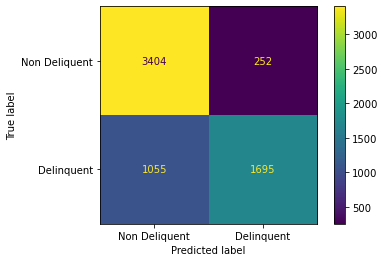

In [13]:
plot_confusion_matrix(random_search,
                   X_Train,
                   Y_Train,
                   values_format = 'd',
                   display_labels = ["Non Deliquent", "Delinquent"]);

Y_Predict_Train = random_search.predict(X_Train)
print(accuracy_score(Y_Train, Y_Predict_Train))
print(classification_report(Y_Train, Y_Predict_Train))
pd.crosstab(Y_Train, Y_Predict_Train)
cf_matrix_train = confusion_matrix(Y_Train, Y_Predict_Train)
print(cf_matrix_train)

0.766541822721598
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       913
           1       0.83      0.57      0.68       689

    accuracy                           0.77      1602
   macro avg       0.79      0.74      0.75      1602
weighted avg       0.78      0.77      0.76      1602

[[833  80]
 [294 395]]


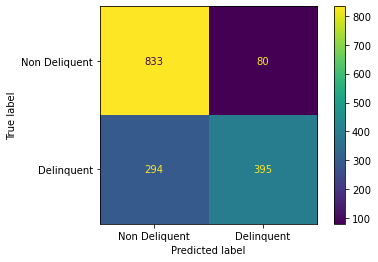

In [14]:
plot_confusion_matrix(random_search,
                   X_Test,
                   Y_Test,
                   values_format = 'd',
                   display_labels = ["Non Deliquent", "Delinquent"]);

Y_Predict = random_search.predict(X_Test)
print(accuracy_score(Y_Test, Y_Predict))
print(classification_report(Y_Test, Y_Predict))
pd.crosstab(Y_Test, Y_Predict)
cf_matrix_train = confusion_matrix(Y_Test, Y_Predict)
print(cf_matrix_train)

In [15]:
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [16]:
Y_Pred = random_search.predict_proba(X_Test)
Y_Pred

array([[0.5748824 , 0.4251176 ],
       [0.71037513, 0.28962487],
       [0.54654056, 0.45345944],
       ...,
       [0.6293228 , 0.37067717],
       [0.3994515 , 0.6005485 ],
       [0.6982924 , 0.30170766]], dtype=float32)

In [17]:
results_df = pd.DataFrame(data={'Probability_Score':df_test['Probability_Score'], 'target':Y_Pred[:,1]})
results_df.to_csv('Calling List_PL.csv', index=False)